# Setup

## Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Installs

In [ ]:
!pip install sentence_transformers -q

     |████████████████████████████████| 85 kB 3.1 MB/s 
     |████████████████████████████████| 4.7 MB 34.3 MB/s 
     |████████████████████████████████| 1.3 MB 52.5 MB/s 
     |████████████████████████████████| 101 kB 11.9 MB/s 
     |████████████████████████████████| 596 kB 70.3 MB/s 
     |████████████████████████████████| 6.6 MB 56.5 MB/s 


## Paths

In [ ]:
DATASET_PUBMED_RCT = './gdrive/Shareddrives/DATASETS/PUBMED_RCT/'
MODEL = './gdrive/Shareddrives/MODELS/all-MiniLM-L6-v2_PubMedRCT_TripletAll-2022-08-08_13-15-12/model'

## Imports

In [ ]:
import pandas as pd

pd.options.display.max_columns = 100
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 300
pd.options.mode.chained_assignment = 'raise'

import json

from tqdm import tqdm

import torch

# Load PubMed-RCT Dataset

In [ ]:
df_train = pd.read_parquet(DATASET_PUBMED_RCT + 'train.parquet')
df_dev = pd.read_parquet(DATASET_PUBMED_RCT + 'dev.parquet')
df_test = pd.read_parquet(DATASET_PUBMED_RCT + 'test.parquet')

In [ ]:
# same text but with different labels
print(f'{len(df_train.index)}')
mask = df_train.groupby('sentence')['label_id'].transform('nunique') > 1
df_train = df_train[~mask].copy()
print(f'{len(df_train.index)}')

180040
179892


In [ ]:
# same text but with different labels
print(f'{len(df_dev.index)}')
mask = df_dev.groupby('sentence')['label_id'].transform('nunique') > 1
df_dev = df_dev[~mask].copy()
print(f'{len(df_dev.index)}')

30212
30212


In [ ]:
# same text but with different labels
print(f'{len(df_test.index)}')
mask = df_test.groupby('sentence')['label_id'].transform('nunique') > 1
df_test = df_test[~mask].copy()
print(f'{len(df_test.index)}')

30135
30122


In [ ]:
train_sentences = list(df_train['sentence'].values)
dev_sentences = list(df_dev['sentence'].values)
test_sentences = list(df_test['sentence'].values)

print(f'train_sentences: {len(train_sentences)}')
print(f'dev_sentences: {len(dev_sentences)}')
print(f'test_sentences: {len(test_sentences)}')

train_sentences: 179892
dev_sentences: 30212
test_sentences: 30122


In [ ]:
y_train_true = list(df_train['label_id'].values)
y_dev_true = list(df_dev['label_id'].values)
y_test_true = list(df_test['label_id'].values)

print(f'y_train_true: {len(y_train_true)}')
print(f'y_dev_true: {len(y_dev_true)}')
print(f'y_test_true: {len(y_test_true)}')

y_train_true: 179892
y_dev_true: 30212
y_test_true: 30122


# Fine Tuned Model

In [ ]:
from sentence_transformers import models, SentenceTransformer

tuned_model = SentenceTransformer(MODEL, device='cuda')

# Tests

## Generate Embeddings

In [ ]:
%time embeddings_gpu_train = tuned_model.encode(train_sentences, convert_to_tensor=True, show_progress_bar=True)
embeddings_cpu_train = embeddings_gpu_train.cpu().numpy()
embeddings_cpu_train.shape

Batches:   0%|          | 0/5622 [00:00<?, ?it/s]

CPU times: user 1min 14s, sys: 2.26 s, total: 1min 16s
Wall time: 1min 12s


(179892, 384)

In [ ]:
%time embeddings_gpu_dev = tuned_model.encode(dev_sentences, convert_to_tensor=True, show_progress_bar=True)
embeddings_cpu_dev = embeddings_gpu_dev.cpu().numpy()
embeddings_cpu_dev.shape

Batches:   0%|          | 0/945 [00:00<?, ?it/s]

CPU times: user 12.4 s, sys: 244 ms, total: 12.6 s
Wall time: 12 s


(30212, 384)

In [ ]:
%time embeddings_gpu_test = tuned_model.encode(test_sentences, convert_to_tensor=True, show_progress_bar=True)
embeddings_cpu_test = embeddings_gpu_test.cpu().numpy()
embeddings_cpu_test.shape

Batches:   0%|          | 0/942 [00:00<?, ?it/s]

CPU times: user 12.3 s, sys: 201 ms, total: 12.5 s
Wall time: 11.6 s


(30122, 384)

## Unsupervised

In [ ]:
from sklearn.cluster import KMeans

num_clusters = len(set(y_test_true))

kmeans_clusterer = KMeans(n_clusters=num_clusters)
%time kmeans_cluster_labels = kmeans_clusterer.fit_predict(embeddings_cpu_test)
len(kmeans_cluster_labels)

CPU times: user 9.12 s, sys: 2.56 s, total: 11.7 s
Wall time: 8.44 s


30122

In [ ]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import rand_score
from sklearn.metrics import mutual_info_score


print(f'Adjusted RI {adjusted_rand_score(y_test_true, kmeans_cluster_labels):.4f}')
print(f'RI {rand_score(y_test_true, kmeans_cluster_labels):.4f}')
print(f'Adjusted MI {adjusted_mutual_info_score(y_test_true, kmeans_cluster_labels):.4f}')
print(f'MI {mutual_info_score(y_test_true, kmeans_cluster_labels):.4f}')
print(f'Silhouette Score {silhouette_score(embeddings_cpu_test, kmeans_cluster_labels):.4f}')

Adjusted RI 0.7349
RI 0.8965
Adjusted MI 0.6678
MI 0.9375
Silhouette Score 0.9898


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


CPU times: user 6min 58s, sys: 7.68 s, total: 7min 6s
Wall time: 6min 36s


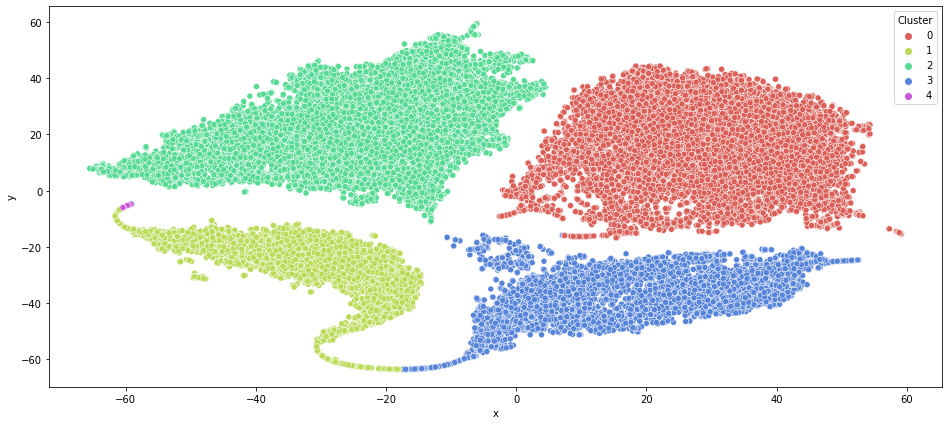

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tSNE=TSNE(n_components=2, init='pca')

%time tSNE_result=tSNE.fit_transform(embeddings_cpu_test)

df_kmeans = pd.DataFrame.from_dict({'x':tSNE_result[:,0],'y':tSNE_result[:,1],'Cluster':kmeans_cluster_labels})

plt.figure(figsize=(16,7))
ax = sns.scatterplot(x='x',y='y',hue='Cluster',palette=sns.color_palette("hls",num_clusters),data=df_kmeans,
               legend="full")

plt.show()

## Supervised

In [ ]:
import math

total = math.ceil(math.sqrt(len(train_sentences)))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

models = [
    ('DecisionTreeClassifier', tree.DecisionTreeClassifier()),
    ('KNeighborsClassifier1', KNeighborsClassifier(n_neighbors=1, weights='distance')),
    ('KNeighborsClassifierSqrt', KNeighborsClassifier(n_neighbors=total, weights='distance')),
    ('KNeighborsClassifier5', KNeighborsClassifier(weights='distance')),
    ('RandomForestClassifier', RandomForestClassifier()),
    ('MLPClassifier', MLPClassifier()),
]

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import f1_score
import time

output_results = []

for model in models:
  output_dict = {
      'model': model[0]
  }
  print(model[0])
  clf = model[1]
  start = time.time()
  clf = clf.fit(embeddings_cpu_train, y_train_true)
  end = time.time()
  y_pred = clf.predict(embeddings_cpu_test)
  
  output_dict['acc'] = accuracy_score(y_test_true, y_pred)
  output_dict['f1_macro'] = f1_score(y_test_true, y_pred, average='macro')
  output_dict['f1_micro'] = f1_score(y_test_true, y_pred, average='micro')  
  output_dict['f1_weighted'] = f1_score(y_test_true, y_pred, average='weighted')
  output_dict['time'] = end - start
  
  output_results.append(output_dict)
pd.DataFrame(output_results)

DecisionTreeClassifier
KNeighborsClassifier1
KNeighborsClassifierSqrt
KNeighborsClassifier5
RandomForestClassifier
MLPClassifier


,model,acc,f1_macro,f1_micro,f1_weighted,time
0,DecisionTreeClassifier,0.798586,0.727906,0.798586,0.799879,1177.774052
1,KNeighborsClassifier1,0.822190,0.753050,0.822190,0.822703,0.087291
2,KNeighborsClassifierSqrt,0.851869,0.787953,0.851869,0.851282,0.075987
3,KNeighborsClassifier5,0.848848,0.783208,0.848848,0.848325,0.080570
4,RandomForestClassifier,0.857015,0.793728,0.857015,0.855286,2471.842743
5,MLPClassifier,0.830025,0.665204,0.830025,0.803724,260.379599


In [ ]:
models = [
  ('SVM', SVC()),
]

In [ ]:
output_results = []

for model in models:
  output_dict = {
      'model': model[0]
  }
  print(model[0])
  clf = model[1]
  start = time.time()
  clf = clf.fit(embeddings_cpu_train, y_train_true)
  end = time.time()
  y_pred = clf.predict(embeddings_cpu_test)
  
  output_dict['acc'] = accuracy_score(y_test_true, y_pred)
  output_dict['f1_macro'] = f1_score(y_test_true, y_pred, average='macro')
  output_dict['f1_micro'] = f1_score(y_test_true, y_pred, average='micro')  
  output_dict['f1_weighted'] = f1_score(y_test_true, y_pred, average='weighted')
  output_dict['time'] = end - start
  
  output_results.append(output_dict)
pd.DataFrame(output_results)

SVM


,model,acc,f1_macro,f1_micro,f1_weighted,time
0,SVM,0.829991,0.665184,0.829991,0.80367,2226.109307
